In [4]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

import warnings
warnings.filterwarnings('ignore')

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":2.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.viridis
savedir= '/home/dascoli/odeformer/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

gpu_index = get_most_free_gpu()

parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)        
args = parser.parse_args(args=[])
args.debug = False
env = FunctionEnvironment(args)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
runs = []
logs = []
global_path = '/home/dascoli/odeformer/experiments/'

paths = [
    #'dropout'
    #'int_base'
    #'precision'
    #"curriculum"
    #"first"
    #"second"
    #"use_cross_attention"
    #"third"
    "fixed_init_scale"
       ]


NaN = np.nan
Infinity = np.nan

for path in paths:
    path = os.path.join(global_path, path)
    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        #try : 
        latest, latest_pmlb = -1, -1
        run = {}
        args = pickle.load(open(dirname+'/params.pkl', 'rb'))
        run['args'] = args
        run['logs'] = []
        run['pmlb'] = []
        run['num_params'] = []
        logfile = dirname+'/train.log'
        f = open(logfile, "r")
        for line in f.readlines():
            if '__log__' in line or '__pmlb__' in line: 
                log = eval(line[line.find('{'):].rstrip('\n'))
                epoch = log['epoch']
                if '__pmlb__' in line:
                    if epoch <= latest_pmlb: continue
                    latest_pmlb = epoch
                    run['pmlb'].append(log)
                else:
                    if epoch <= latest: continue
                    latest = epoch
                    run['logs'].append(log)
        f.close()
        args.output_dir = Path(dirname)
        runs.append(run)
    print('{} fails'.format(fails))
    
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/home/dascoli/odeformer/experiments/fixed_init_scale/
2 runs found
/home/dascoli/odeformer/experiments/fixed_init_scale/exp_fixed_init_scale_True
/home/dascoli/odeformer/experiments/fixed_init_scale/exp_fixed_init_scale_False
0 fails


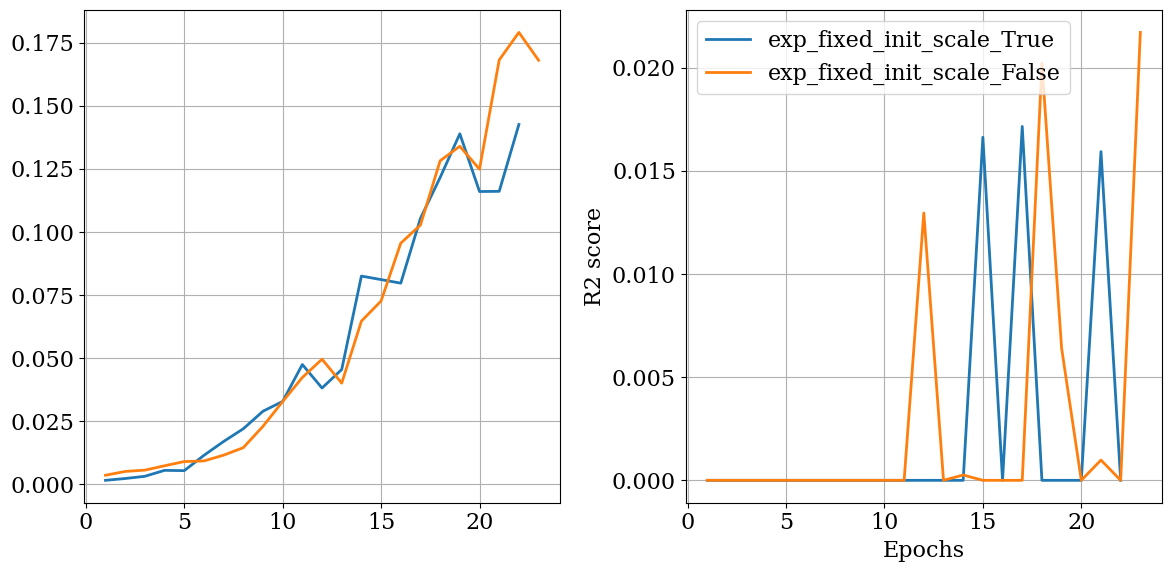

In [3]:
constraints = {
    #'optimizer': ['adam_cosine,warmup_updates=5000,init_period=50000,period_mult=1.5,lr_shrink=0.5'],
}
selected_runs, selected_params = select_runs(runs, params, constraints)
latest = min([len(run['logs'])-1 for run in selected_runs])
#selected_runs = runs

fig, axarr = plt.subplots(1,2,figsize=(12,6))

for run in selected_runs[:]:
    args = run['args']
    times = np.array(range(len(run['logs'])))#[:latest]
    r2    = [run['logs'][t]['r2_zero']      for t in times]
    acc    = [run['logs'][t]['accuracy_l1_1e-1']      for t in times]
    label = args.exp_id
    #label = 'dim {}'.format(lab)
    y = r2
    #print(loss,correct,perfect,additional)
    axarr[0].plot(times+1, y, label=label)

for run in selected_runs[:]:
    args = run['args']
    times = np.array(range(len(run['pmlb'])))#[:latest]
    r2    = [run['pmlb'][t]['r2_zero']      for t in times]
    acc   = [run['pmlb'][t]['accuracy_l1_1e-1']      for t in times]
    snmse    = [run['pmlb'][t]['snmse']      for t in times]
    label = args.exp_id
    #label = 'dim {}'.format(lab)
    y = r2
    #print(loss,correct,perfect,additional)
    axarr[1].plot(times+1, y, label=label)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('R2 score')
#plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'simplification_loss_{}.pdf'.format('float' if args.float_sequences else 'int'))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


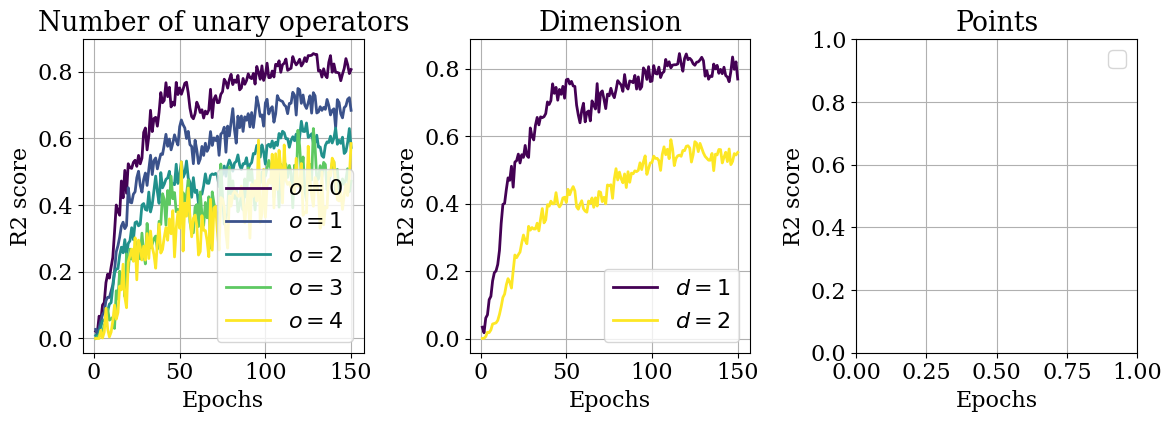

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


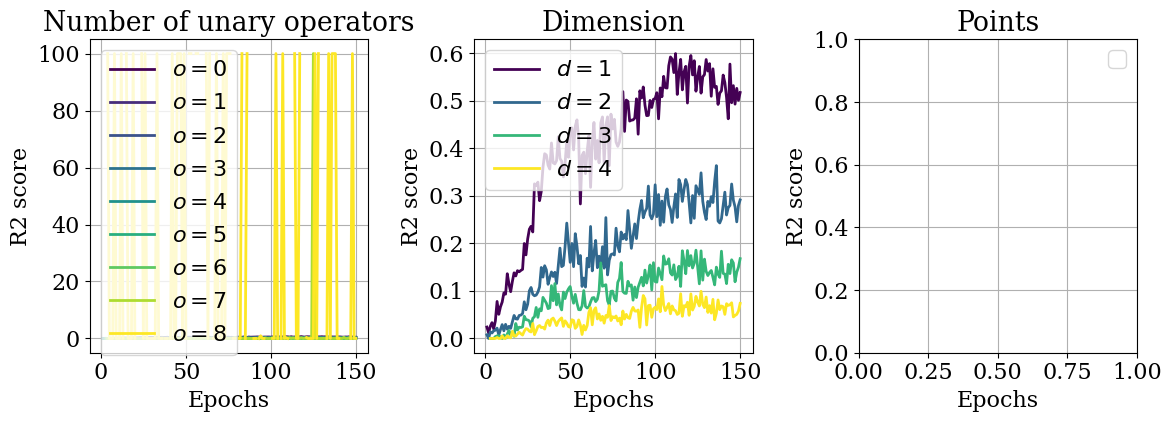

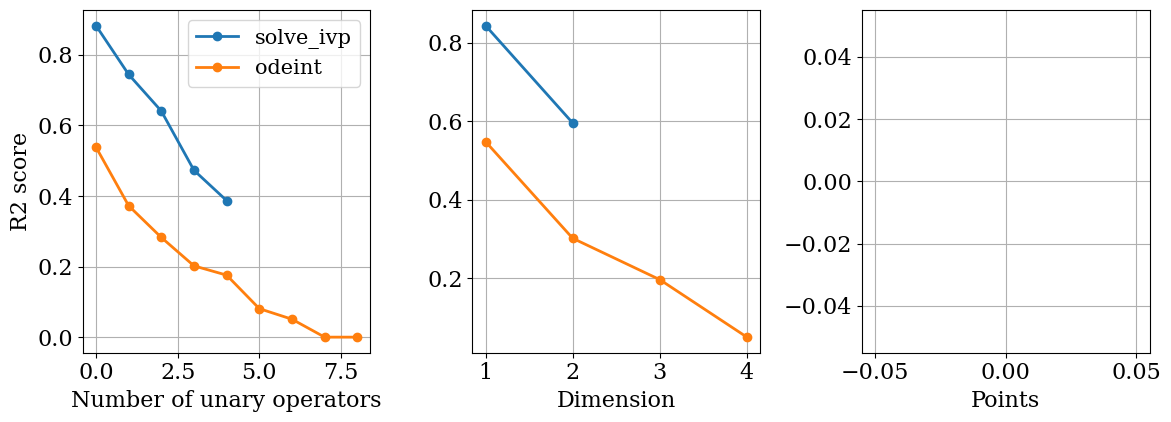

In [44]:
metrics = ['r2_zero_info_n_unary_ops', 'r2_zero_info_dimension', 'r2_zero_info_n_points']
legends = ['o', 'd', 'n']
labels = ['Number of unary operators', 'Dimension', 'Points']

selected_runs = [runs[0],runs[-1]]

for run in selected_runs:
    if not run['logs']:continue
    args = run['args']
    fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        keys = keys[::max(1,len(keys)//5)]
        for j, key in enumerate(keys):
            label = int(key.split('_')[-1])
            if metric == 'additional': label = args.more_tolerance.split(',')[int(label)-1]
            for t in range(len(run['logs'])):
                if key not in run['logs'][t]: run['logs'][t][key] = 100
            acc = [run['logs'][t][key] for t in range(len(run['logs']))][:150]
            axarr[i].plot(range(1, len(acc)+1), acc, label='${}={}$'.format(legends[i],label), color = cmap(j/(len(keys)-1)))
        axarr[i].set_title(labels[i])
        axarr[i].legend()
    for ax in axarr:
        #ax.set_xscale('log')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('R2 score')
    #for n, ax in enumerate(axarr):
    #    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
    plt.tight_layout()
    plt.savefig(savedir+'acc_vs_time.pdf')
    plt.show()    

##########       
    
suffix = ''
fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
for run in selected_runs:
    if not run['logs']:continue
    args = run['args']
    log = run['logs'][-1]
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        if metric == 'additional':
            x = [eval(x) for x in args.more_tolerance.split(',')]
            axarr[i].set_xscale('log')
        elif metric == 'ops':
            x = [int(k.split('_')[-1]) for k in keys]
        else:
            x = [int(k.split('_')[-1]) for k in keys]
        y = [log[k] for k in keys]
        label = args.ode_integrator
        axarr[i].plot(x, y, label = label, marker='o')
        axarr[i].set_xlabel(r'{}'.format(labels[i]))
        #axarr[i].set_ylim(bottom=0, top=100)
        #axarr[i].set_yscale('symlog')
#for n, ax in enumerate(axarr):
#    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
axarr[0].set_ylabel('R2 score')
axarr[0].legend(fontsize=15)
plt.tight_layout()
title = 'acc_vs_difficulty.pdf'
plt.savefig(savedir+title)
plt.show()    

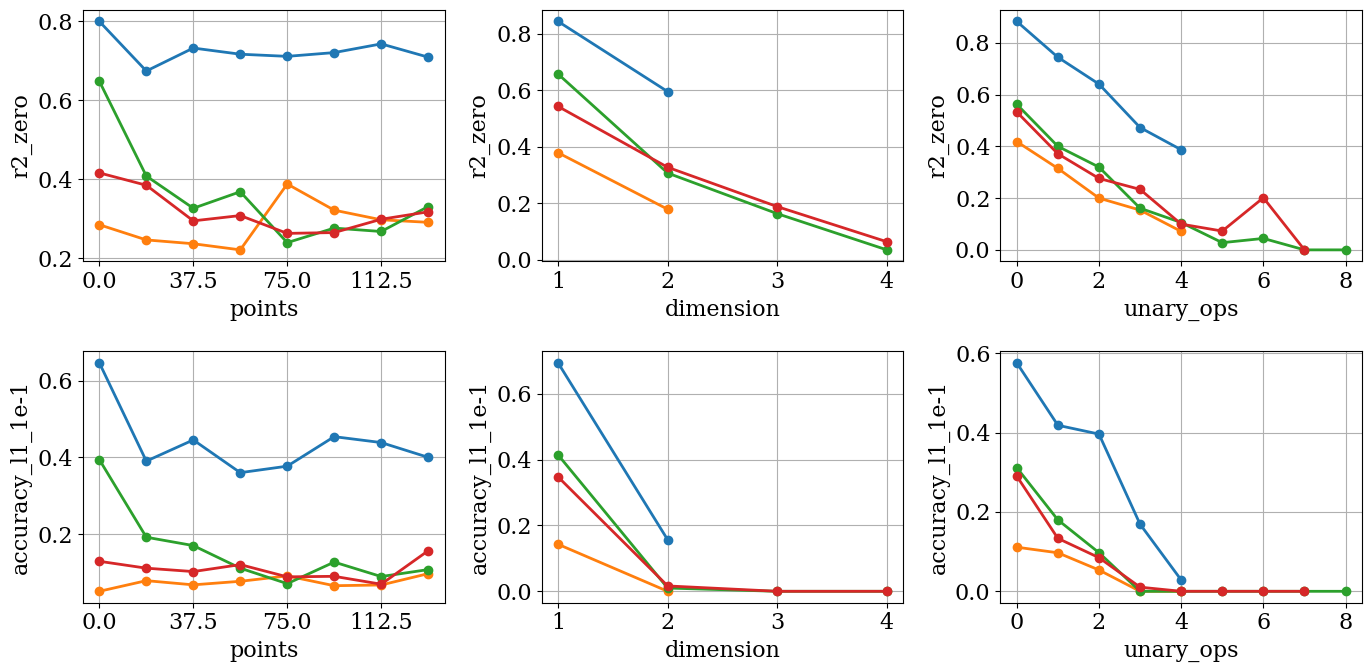

In [6]:
metrics = ['r2_zero', 'accuracy_l1_1e-1']
ablations = ['info_n_points', 'info_dimension', 'info_n_unary_ops']

# plot r2_zero vs info_n_points
fig, axarr = plt.subplots(len(metrics), len(ablations), figsize=(7*len(metrics),7))
for run in selected_runs:
    args = run['args']
    df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
    df = df.drop(columns=['predicted_trees', 'trees'])
    k = 8# bin info_n_points into k bins
    df['info_n_points'] = pd.cut(df['info_n_points'], bins=k, labels=np.arange(k)*df['info_n_points'].max()/k)
    for i, metric in enumerate(metrics):
        for j, ablation in enumerate(ablations):
            df.groupby(ablation)[metric].mean().plot(ax=axarr[i,j], marker='o', label=ablation)
            axarr[i,j].set_xlabel(ablation.lstrip('info_'))
            axarr[i,j].set_ylabel(metric)
            #axarr[i,j].set_xscale('log')
plt.tight_layout()
plt.show()


# Load model

In [24]:
run = selected_runs[0]
args = run['args']
extra_args = {'rescale':True,
              'use_cross_attention':True}
with stdout_redirected():
    dstr = load_run(run, extra_args=extra_args)

Reloading checkpoint from /home/dascoli/odeformer/experiments/third/exp_ode_integrator_solve_ivp_max_dimension_2/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 195 / iteration 195000 ...


In [34]:
dstr.rescale=False
dstr.average_trajectories=True

dstr.model.decoder.use_cross_attention=True
dstr.model.beam_type = 'sampling'
dstr.model.beam_size = 1
dstr.model.beam_temperature = .1

-2.97*x_0*x_1 + 4.1*x_0 - 0.04  ,  3.186*x_0*x_1 - 5.5*x_1 + 0.2


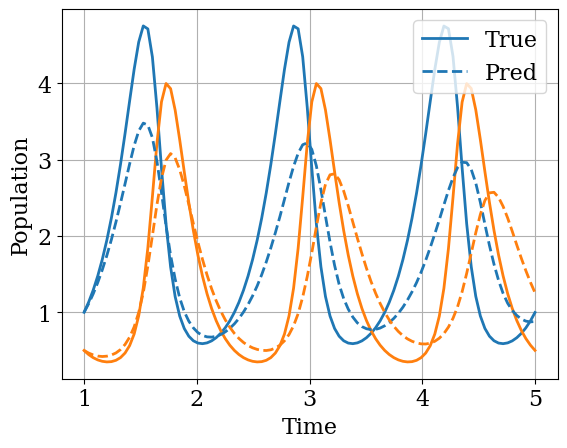

In [41]:
a = 3*1.5 # growth rate of rabbits
b = 3*1 # death rate of rabbits
c = 3*2 # death rate of foxes
d = 3*1 # growth rate of foxes
def lotka_volterra(X, t):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([ a*X[0] - b*X[0]*X[1] ,
                     -c*X[1] + d*X[0]*X[1] ])

# solve ODE
times, trajectories = [],[]
np.random.seed(4)
for _ in range(5):
    time = np.linspace(1,5,100)     # time
    y0 = np.random.uniform(0,2,size=(2,)) # initial conditions
    y0 = [1,.5]
    trajectory = integrate.odeint(lotka_volterra, y0, time)
    times.append(time)
    trajectories.append(trajectory)

plt.figure()
plt.plot(time, trajectories[0][:,0], color='C0', label='True')
plt.plot(time, trajectories[0][:,1], color='C1')


candidates = dstr.fit(times, trajectories)
for tree in candidates[0]:
    print(env.simplifier.readable_tree(tree))
    pred_trajectory = integrate_ode(trajectories[0][0], time, tree, "solve_ivp", debug=True)
    try:
        plt.plot(time, pred_trajectory[:,0], color='C0', ls='--', label='Pred')
        plt.plot(time, pred_trajectory[:,1], color='C1', ls='--')
    except: 
        print(traceback.format_exc())
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

-3.95*x_0**2 + 13.75*x_0 + 0.9


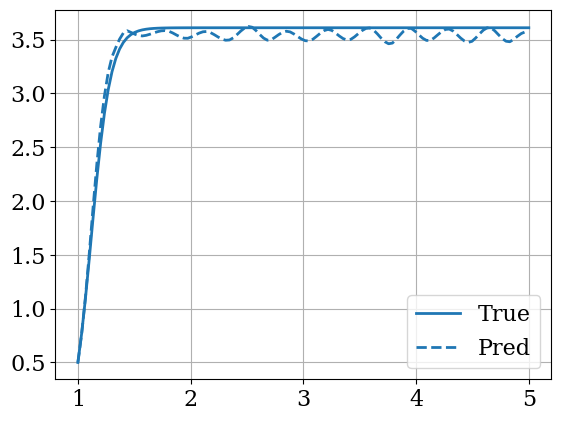

In [31]:
a = -3
b = 10
c = 3
def quadratic(X, t):
    return np.array([a*X[0]**2+b*X[0]+c])

# solve ODE
times = np.linspace(1, 5, 120)     # time
y0 = [.5] # initials conditions
trajectory = integrate.odeint(quadratic, y0, times)
# plot results
plt.plot(times, trajectory[:,0], color='C0', label='True')

candidates = dstr.fit(times, trajectory)
tree = candidates[0][0]
for tree in candidates[0][:]:
    print(env.simplifier.readable_tree(tree))
    pred_trajectory = integrate_ode(y0,times, tree, "solve_ivp")
    plt.plot(sorted(times), pred_trajectory[:,0], color='C0', ls='--', label='Pred')
plt.legend()
plt.show()

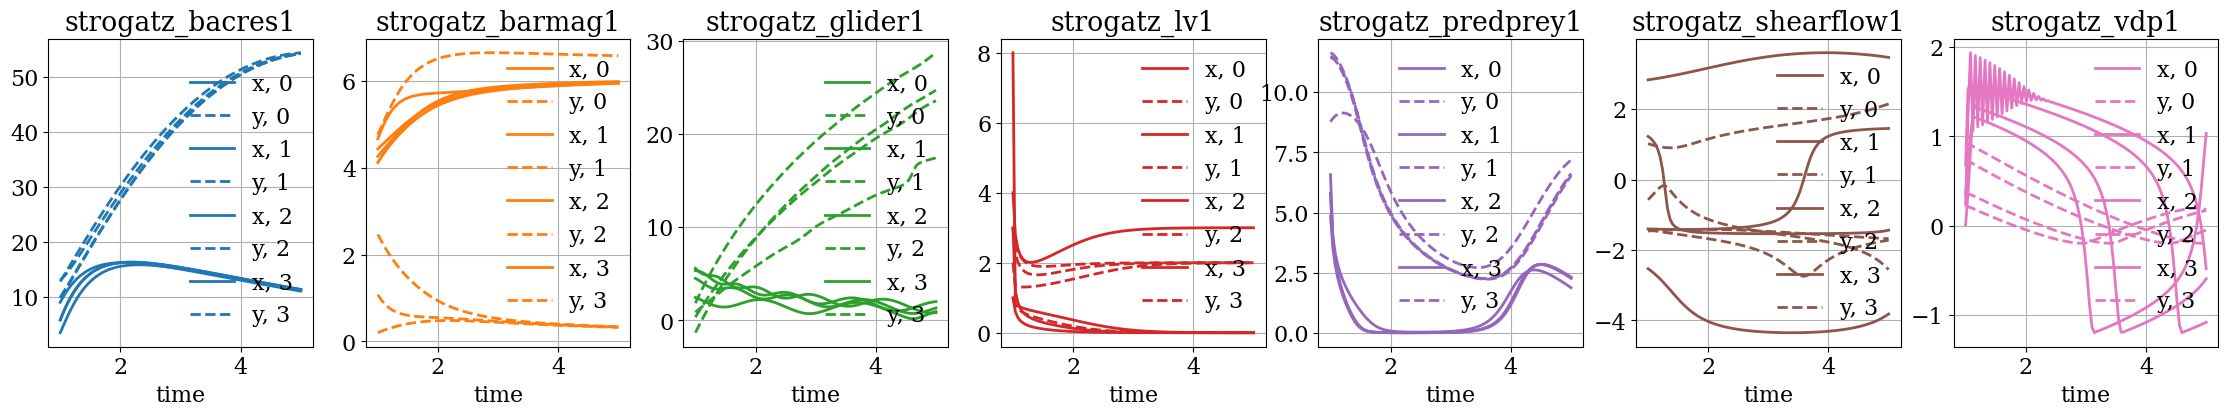

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from pmlb import fetch_data, dataset_names
strogatz_names = [name for name in dataset_names if "strogatz" in name and "2" not in name]
n = len(strogatz_names)

times = np.linspace(1, 5, 100)

# Returns a pandas DataFrame
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
for i ,name in enumerate(strogatz_names):
    data = fetch_data(name)
    x = data['x'].values
    y = data['y'].values
    for j in range(4):
        start = j * len(times)
        stop = (j+1) * len(times)
        axarr[i].plot(times, x[start:stop], color=f"C{i}", ls='-', label=f"x, {j}")
        axarr[i].plot(times, y[start:stop], color=f"C{i}", ls='--', label=f"y, {j}")
    axarr[i].set_xlabel("time")
    axarr[i].legend(ncol=1, loc="best", frameon=False)
    axarr[i].set_title(name)
plt.show()

In [9]:
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
dstr.rescale = False
dstr.beam_size = 10

for i ,name in enumerate(strogatz_names[::]):
    data = fetch_data(name)
    print(i, end=' ')
    x = data['x'].values.reshape(-1,1)[:100]
    y = data['y'].values.reshape(-1,1)[:100]
    trajectory = np.concatenate((x,y), axis=1)
    #tree = plot_predictions(times, trajectory, dstr, verbose=False)
    #print(env.simplifier.readable_tree(tree))

    for dim in range(len(trajectory[0])):
        axarr[i].plot(times, trajectory[:,dim], color=f'C{dim}', label='True')
    candidates = dstr.fit(times, trajectory)
    for tree in candidates[0][:1]:
        pred_trajectory = integrate_ode(trajectory[0], times, tree, "solve_ivp", debug=False)
        try:
            for dim in range(len(trajectory[0])):
                axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
        except: 
            print(traceback.format_exc())
plt.show()


NameError: name 'n' is not defined

In [10]:
datasets = {}
for file in glob.glob("invar_datasets/*"):
    with open(file) as f:
        lines = (line for line in f if not line.startswith('%') and not line.startswith('x'))
        data = np.loadtxt(lines)
        data = data[data[:,0]==0]
    datasets[file.split('/')[-1]] = data
n = len(datasets)

0 Traceback (most recent call last):
  File "/tmp/ipykernel_30785/3438772943.py", line 22, in <module>
    axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
TypeError: 'NoneType' object is not subscriptable

1 2 3 4 5 6 7 Traceback (most recent call last):
  File "/tmp/ipykernel_30785/3438772943.py", line 22, in <module>
    axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
TypeError: 'NoneType' object is not subscriptable

8 Traceback (most recent call last):
  File "/tmp/ipykernel_30785/3438772943.py", line 22, in <module>
    axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
TypeError: list indices must be integers or slices, not tuple

9 Traceback (most recent call last):
  File "/tmp/ipykernel_30785/3438772943.py", line 22, in <module>
    axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
TypeError: list indices must be integers or slices, not

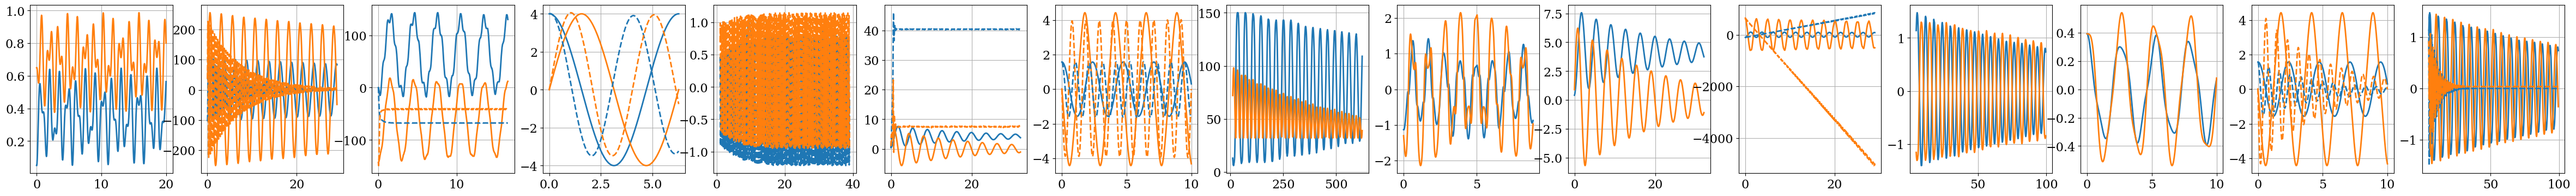

In [18]:
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
dstr.rescale = True
tmax = 120
for i, (name, data) in enumerate(datasets.items()):
    #if i==5: break
    print(i, end=' ')
    times = data[:,1]
    x     = data[:,2]
    y     = data[:,3]
    trajectory = np.concatenate([x[:,None], y[:,None]], axis=1)
    idx = np.random.permutation(len(times))
    shuffled_times, x, y = times[idx], x[idx], y[idx]
    shuffled_trajectory = np.concatenate([x[:,None], y[:,None]], axis=1)

    for dim in range(len(trajectory[0])):
        axarr[i].plot(times, trajectory[:,dim], color=f'C{dim}', label='True')
    candidates = dstr.fit(shuffled_times, shuffled_trajectory)
    for tree in candidates[0][:1]:
        pred_trajectory = integrate_ode(trajectory[0], times, tree, "solve_ivp", debug=False)
        try:
            for dim in range(len(trajectory[0])):
                axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
        except: 
            print(traceback.format_exc())
plt.show()

# Play with generator

0.22*x_0*x_1 - 0.098

6.54*x_0 - 0.37*x_1 - 0.1459*(0.4683*x_0 + 1)**2 - 0.915

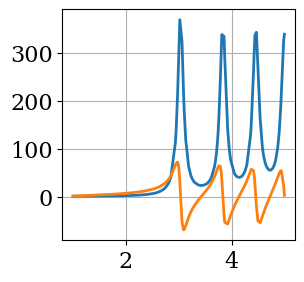

-2.678*x_0 + 1.0643*(0.1926*x_1 - 1)**2 - 0.527

-8.62*x_0*(0.836*x_1 + 0.836*cos(0.148*x_1 - 0.689)) + 9.7*x_0 - 0.035*x_1 - 0.035*sin(0.502*x_0 - 5.39) + 0.679

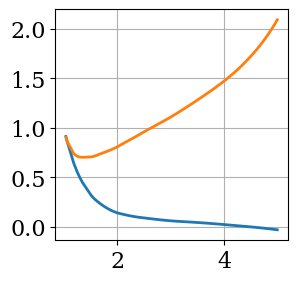

-1.713*x_0 + 0.04*x_1**2 + 0.04*x_1 - 0.272

3.089*x_0 - 6.7*x_1 + 7.87

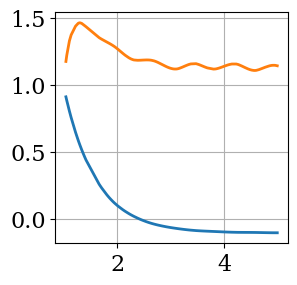

-0.754*x_0*x_1 - 3.011*x_0 - 2.44*x_1 - 5.43

8.54*x_0 - 1.4226*sqrt(0.051*x_0 + 1) - 0.2219*(x_1 + 0.9485)**2 + 0.73

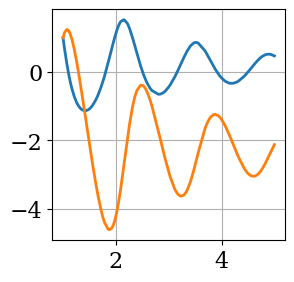

x_1*(0.208*x_0 + 0.208*x_1) - 0.641

0.209*x_0 - 0.054*x_1 + 0.273*cos(5.69*x_0 + 9.7) + 0.419

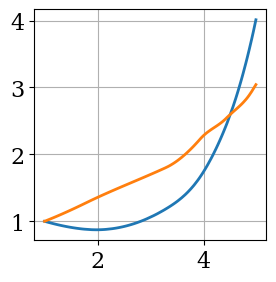

4.0*x_1*(-0.189*x_0*x_1 + 0.852*x_0 + 0.852*x_1) + 4.0*x_1 - 0.083

4.46*x_0 - 8.87*x_1 - 9.33 - 4.41/(0.715*x_0 - 3.91)

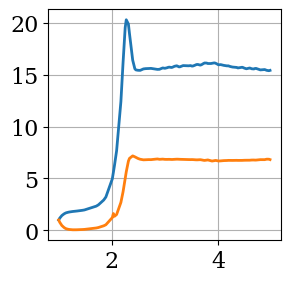

-9.02*x_0 - 0.675*x_1 + 0.47*sin(0.17*x_0 - 5.3) - 0.91

12.6736*(-1.77*x_0 - 1.2135*(x_0 - 0.2271)**2)*(-0.0329*x_1 - 1)**2 + 0.988

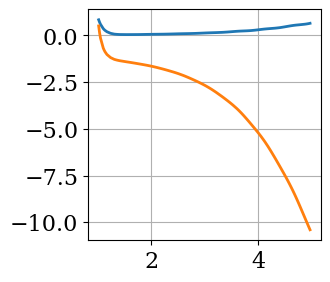

x_0*(-5.56*x_1**2 - 0.67*x_1) + 0.761

0.587*x_0 - 0.856*x_1 - 0.424 - 0.856/(-0.836*x_0 - 0.749)

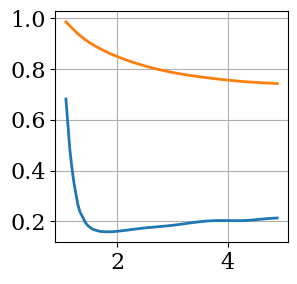

-1.376*x_0 + 7.304*x_1 - 1.6

1.68*x_0*x_1 + 1.68*x_0 - 9.03

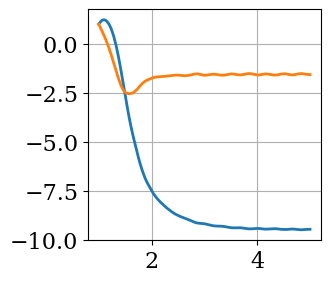

-5.53*x_0 + 3.509*x_1 - 0.85

-0.755*x_0 + 4.895*x_1 + 6.13

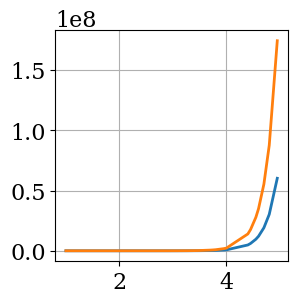

: 

In [28]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.min_dimension = 2
args.max_dimension = 2
#args.prob_t = 0
#args.max_dimension = 4
#args.max_unary_ops = 4
#args.max_unary_depth = 4
#args.prob_prefactor = 1
#args.use_controller = True
args.debug = False
args.fixed_init_scale = True
#args.use_sympy = False
args.ode_integrator = 'solve_ivp'
    
env = FunctionEnvironment(args)

env.rng = np.random.RandomState()
i=0
for _ in range(1000):
    samples, error = env._gen_expr(train=True)
    if i==10: break
    if not error:
        tree = samples["tree"]
        tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
        for expr in tree_sympy:
            display(expr)
        plt.figure(figsize=(3,3))
        for dim in range(samples["infos"]["dimension"]):
            #print(samples["trajectory"][-10:])
            plt.plot(samples["times"], samples["trajectory"][:, dim])
        plt.show()
        i+=1


System :


x_0**2*(3.35*x_0 - 6.51*x_1 - 6.51/(0.907*x_0 + 0.999)) + 3.53

-0.33*x_0 + 0.825*x_0/(0.66*x_1 + 0.427) - 0.658*x_1 + 0.186

(100, 2)


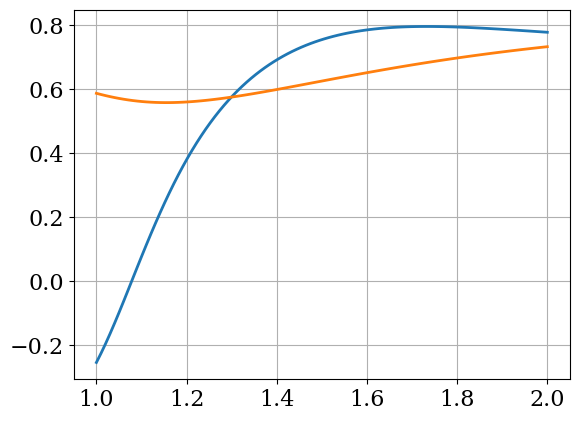

In [80]:
rng = np.random.RandomState(18)
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=rng, dimension=2, nb_unary_ops=1)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = rng.randn(dimension)
t = np.linspace(1,2,100)

#trajectory = integrate_ode(y0, t, tree, ode_integrator='odeint', debug=True)
trajectory = integrate_ode(y0, t, tree, ode_integrator='jax', debug=True)

for dim in range(dimension):
    plt.plot(t,trajectory[:,dim])


In [57]:
trajectory[0]

Array([-0.20161551,  0.4996451 ], dtype=float32, weak_type=True)

In [48]:
trajectory

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [26]:
tree_sympy

[16.58*x_0*x_1**2*cos(4.85*x_0 + 0.55) - 0.5,
 x_1*(-0.119*x_0*x_1 - 5.7*x_0 - 0.119/(1.86*x_0 + 0.55)) + 0.314]

In [28]:
from symbolicregression.envs.export_jax import *
dimension=2
tree = tree_sympy[0]
symbols = list(tree.free_symbols)
jax_trees, jax_params = [], []
for tree in tree_sympy:
    jax_tree, jax_param = sympy2jax(tree, symbols)
    jax_trees.append(jax_tree)
    jax_params.append(jax_param)
def func(x):
    print(jax_trees[0](x, jax_params[0]).shape)
    return jax.numpy.concatenate([jax_tree(x, jax_param).reshape(-1,1) for jax_tree, jax_param in zip(jax_trees, jax_params)], axis=1)

In [29]:
import jax.random as random
key = random.PRNGKey(0)
X = random.normal(key, (10, 2))
func(X).shape

(10,)


(10, 2)

In [77]:
def f(t, y):
    return tree_jax(*y)

y0 = np.random.randn(dimension)
t = np.linspace(1,2,100)
trajectory = integrate_ode(y0, t, tree, ode_integrator='jax', debug=True)

AttributeError: 'Add' object has no attribute 'infix'

In [ ]:
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=2)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = np.random.randn(dimension)
t = (0,1)
def func(t,y):
    return tree.val([y],t)[0]
while True:
    import warnings
    with warnings.catch_warnings(record=True) as caught_warnings:
        #sol = odeint(func, y0, t)
        sol = solve_ivp(func, t, y0)
    if caught_warnings:
        print('hi')
        print('Warning: ', caught_warnings[0].message)
        continue
    break

t = sol.t
sol = sol.y.T
for dim in range(dimension):
    plt.plot(t,sol[:,dim])


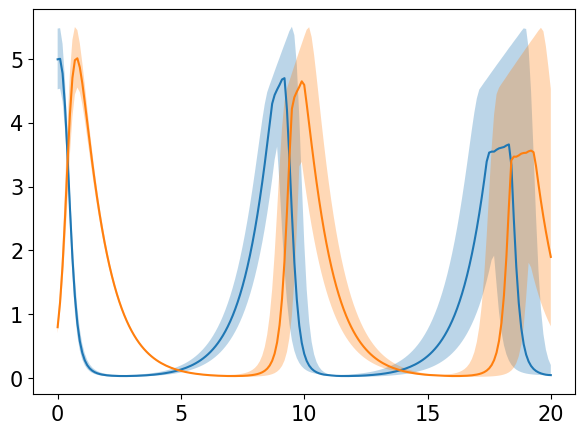

In [6]:
from numbalsoda import lsoda_sig, lsoda
from matplotlib import pyplot as plt
import numpy as np
import numba as nb

@nb.cfunc(lsoda_sig)
def f(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]
    du[1] = u[0]*u[1]-u[1]

funcptr = f.address
t_eval = np.linspace(0.0,20.0,201)
np.random.seed(0)

def main(n):
    u1 = np.empty((n,len(t_eval)), np.float64)
    u2 = np.empty((n,len(t_eval)), np.float64)
    for i in nb.prange(n):
        u0 = np.empty((2,), np.float64)
        u0[0] = np.random.uniform(4.5,5.5)
        u0[1] = np.random.uniform(0.7,0.9)
        usol, success = lsoda(funcptr, u0, t_eval, rtol = 1e-8, atol = 1e-8)
        u1[i] = usol[:,0]
        u2[i] = usol[:,1]
    return u1, u2

u1, u2 = main(10000)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])
low, med, high = np.quantile(u1,(.025,.5,.975),axis=0)
ax.plot(t_eval,med)
ax.fill_between(t_eval,low,high,alpha=0.3)
low, med, high = np.quantile(u2,(.025,.5,.975),axis=0)
ax.plot(t_eval,med)
ax.fill_between(t_eval,low,high,alpha=0.3)
plt.show()

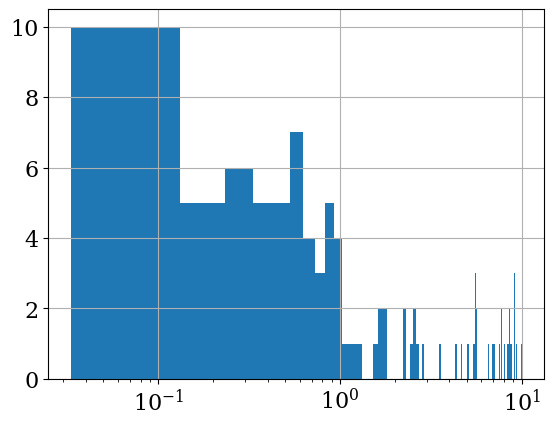

In [10]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.max_exponent_prefactor = 1
args.debug=False
args.ode_integrator = 'solve_ivp'
    
env = FunctionEnvironment(args)

rng = np.random.RandomState(0)
nums = []
for _ in range(100):
    nums.append(abs(float(env.generator.generate_float(rng))))
plt.hist(nums, bins=100)
plt.xscale('log')